In [ ]:
#pip install pandahouse

In [ ]:
import pandahouse

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [ ]:
q = """
SELECT exp_group, user_id, sum(action = 'like') as likes, sum(action = 'view') as views,
likes/views as ctr
FROM simulator_20230920.feed_actions
WHERE toDate(time) between '2023-08-29' and '2023-09-04' and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [ ]:
from scipy import stats
import seaborn as sns
import numpy as np

In [ ]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var = False
                )

TtestResult(statistic=0.4051491913112757, pvalue=0.685373331140751, df=15811.22649797086)

Видим, что t-test не прокрасился, то есть нет оснований откронить нулевую гипотезу о равенстве средних.

In [ ]:
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


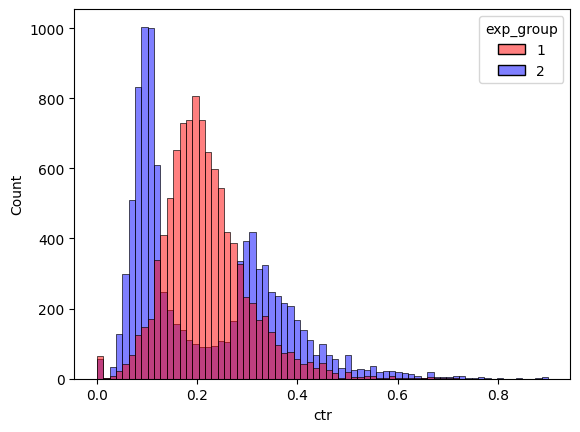

In [ ]:
groups = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

Видим правый хвост 2 группы, где ctr больше по значению, нужно сохранить эту группу пользователей и проработать над левым хвостом второй группы.

In [ ]:
df[df.exp_group == 1].ctr.mean(), df[df.exp_group == 2].ctr.mean()

(0.216773994120072, 0.2161016893237817)

In [ ]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Можем отклонить нулевую гипотезу. Тест Манна Уитни рпокрасился, значит распределения ctr отличаются.

In [ ]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
  smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
  return smothed_ctr

In [ ]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].likes.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].likes.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()
#sns.displot(group1.ctr, kde = False)

In [ ]:
group1['smothed_ctr_1'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
group2['smothed_ctr_2'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

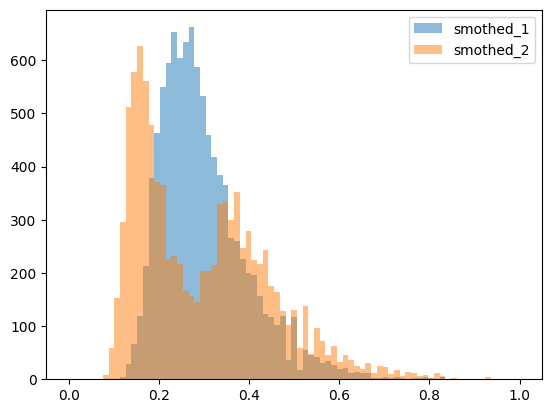

In [ ]:
import random

from matplotlib import pyplot

x = np.linspace(0, 1, 400)
bins = np.linspace(0, 1, 80)

pyplot.hist(group1['smothed_ctr_1'], bins, alpha = 0.5, label='smothed_1')
pyplot.hist(group2['smothed_ctr_2'], bins, alpha = 0.5, label='smothed_2')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
stats.ttest_ind(group1.smothed_ctr_1,
                group2.smothed_ctr_2,
                equal_var = False
                )

TtestResult(statistic=0.6916884975933935, pvalue=0.48914233014036046, df=17159.564739089637)

In [ ]:
stats.mannwhitneyu(group1.smothed_ctr_1, group2.smothed_ctr_2,  alternative = 'two-sided')

MannwhitneyuResult(statistic=53594835.0, pvalue=3.3677100742419525e-24)

Сглаженный ctr не изменил ситуацию.

In [ ]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)

    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)



In [ ]:
import matplotlib.pyplot as plt

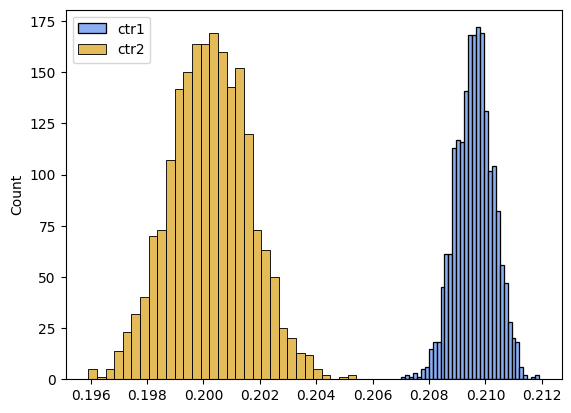

In [ ]:
sns.histplot(ctr1, color = 'cornflowerblue', legend = True)
sns.histplot(ctr2, color = 'goldenrod', legend = True)
plt.legend(['ctr1', 'ctr2'])
plt.show()

<Axes: ylabel='Count'>

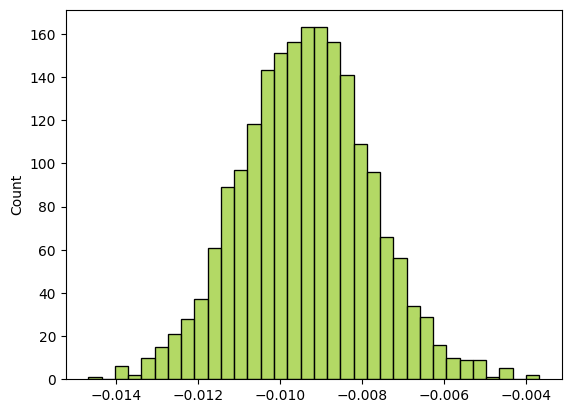

In [ ]:
sns.histplot(ctr2 - ctr1, color = 'yellowgreen')

Видим, что распределения глобальных ctr далеко друг от друга. Можно сделать вывод, что ctr глобально отличаются в друх группах, причем ctr во 2 группе существенно меньше. То есть новая система рекоммендаций не показала значимых улучшений.


> Распределение разности не около нуля. Еще одно объяснение того, что группы отличаются.











In [ ]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (
SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM simulator_20230920.feed_actions
WHERE toDate(time) between '2023-08-29' and '2023-09-04' and exp_group in (1, 2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""



In [ ]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [ ]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [ ]:
#и t-тест тоже
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   equal_var = False)

TtestResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07, df=63.82788260732127)

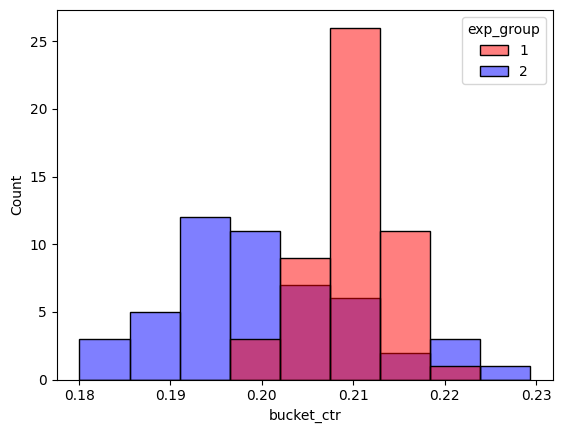

In [57]:
groups = sns.histplot(data = df, x = 'bucket_ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

Побакетное преобразование так же показывает, что центр первого распределения находится правее(ctr больше).

Можем сказать, что новый алгоритм рекоммендаций не бесполезен, однако его нужно доработать.